# Install and import necessary libraries

In [1]:
pip install pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import EMNIST
import torch.nn as nn
import torchvision
import torchvision.models as models
import torch.optim as optim
import random
from torch.utils.data import Subset
import matplotlib.pyplot as plt
import numpy as np
import tkinter as tk
from PIL import Image, ImageDraw
import string

# Load and preprocess dataset

In [4]:
transform = transforms.Compose([
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


full_train_dataset = EMNIST(root='./data', split='letters', train=True, download=True, transform=transform)
full_test_dataset = EMNIST(root='./data', split='letters', train=False, download=True, transform=transform)


train_indices = random.sample(range(len(full_train_dataset)), 8000)
test_indices = random.sample(range(len(full_test_dataset)), 500)

train_dataset = Subset(full_train_dataset, train_indices)
test_dataset = Subset(full_test_dataset, test_indices)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

100%|██████████| 561753746/561753746 [00:07<00:00, 79842778.55it/s]


Extracting ./data/EMNIST/raw/gzip.zip to ./data/EMNIST/raw


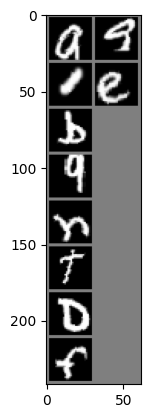

Labels:     1     9     2    17    14    20     4     6     7     5


In [5]:
def imshow(img):
    img = img / 2 + 0.5  
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (2, 1, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = dataiter.__next__()
images = images[:10]
labels = labels[:10]

imshow(torchvision.utils.make_grid(images))

print('Labels:', ' '.join('%5s' % labels[j].item() for j in range(10)))

# Import and modify the Resnet18 model

In [ ]:
class UnfrozenResNet18(nn.Module):
    def __init__(self, num_classes=26):
        super(UnfrozenResNet18, self).__init__()
        
        self.network = models.resnet18(pretrained=True)
        
        self.network.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, num_classes)
        
    def forward(self, xb):
        return self.network(xb)

# Train and evaluate the model

In [ ]:
def evaluate(model, test_loader, criterion):
    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    test_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels - 1) ####
            
            test_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == (labels - 1)).sum().item()
    
    accuracy = correct / total
    return test_loss / len(test_loader), accuracy

def train(model, train_loader, test_loader, num_epochs=10):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels - 1) ####
            loss.backward()
            optimizer.step()
            
            running_train_loss += loss.item()
        
        test_loss, test_accuracy = evaluate(model, test_loader, criterion)
        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {running_train_loss / len(train_loader)}, Test Loss: {test_loss}, Test Accuracy: {test_accuracy * 100:.2f}%")


In [ ]:
model18 = UnfrozenResNet18()
train(model18, train_loader, test_loader, num_epochs=15)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/15, Train Loss: 1.6654104323387147, Test Loss: 1.3371052965521812, Test Accuracy: 61.40%
Epoch 2/15, Train Loss: 0.8059205980300903, Test Loss: 0.7413980066776276, Test Accuracy: 75.20%
Epoch 3/15, Train Loss: 0.5950905478000641, Test Loss: 0.7048125341534615, Test Accuracy: 76.40%
Epoch 4/15, Train Loss: 0.5174991106986999, Test Loss: 0.49190085008740425, Test Accuracy: 82.80%
Epoch 5/15, Train Loss: 0.44820867669582365, Test Loss: 0.45359931886196136, Test Accuracy: 84.40%
Epoch 6/15, Train Loss: 0.4127877931594849, Test Loss: 0.4634396992623806, Test Accuracy: 85.60%
Epoch 7/15, Train Loss: 0.3908986302614212, Test Loss: 0.4648913871496916, Test Accuracy: 85.20%
Epoch 8/15, Train Loss: 0.35585842275619506, Test Loss: 0.44967469200491905, Test Accuracy: 84.00%
Epoch 9/15, Train Loss: 0.33606344944238664, Test Loss: 0.44718095660209656, Test Accuracy: 84.60%
Epoch 10/15, Train Loss: 0.3381668884754181, Test Loss: 0.38015275448560715, Test Accuracy: 87.20%
Epoch 11/15, Train Lo

# Develop a Drawing board to enable user input

In [ ]:
class DrawingApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Handwritten Letter Drawing App")
        self.root.geometry("400x400")
        self.canvas = tk.Canvas(self.root, bg="black", width=280, height=280)
        self.canvas.pack(pady=10)

        self.save_button = tk.Button(self.root, text="Save", command=self.save_image)
        self.save_button.pack(pady=5)

        self.clear_button = tk.Button(self.root, text="Clear", command=self.clear_canvas)
        self.clear_button.pack(pady=5)

        self.canvas.bind("<B1-Motion>", self.draw)
        self.canvas.bind("<ButtonPress-1>", self.on_button_press)
        self.canvas.bind("<ButtonRelease-1>", self.on_button_release)

        self.image = Image.new("RGB", (280, 280), "black")
        self.draw_obj = ImageDraw.Draw(self.image)
        self.last_x = None
        self.last_y = None

    def on_button_press(self, event):
        self.last_x = event.x
        self.last_y = event.y

    def on_button_release(self, event):
        self.last_x = None
        self.last_y = None

    def draw(self, event):
        x, y = event.x, event.y
        r = 5
        if self.last_x and self.last_y:
            self.canvas.create_line(self.last_x, self.last_y, x, y, fill="white", width=r * 2, capstyle=tk.ROUND, smooth=True)
            self.draw_obj.line([self.last_x, self.last_y, x, y], fill="white", width=r * 2)
        self.last_x = x
        self.last_y = y

    def save_image(self):
        resized_image = self.image.resize((28, 28), Image.ANTIALIAS)
        resized_image.save("letter_image.png")
        print("Image saved as letter_image.png")

    def clear_canvas(self):
        self.canvas.delete("all")
        self.image = Image.new("RGB", (300, 300), "black")
        self.draw_obj = ImageDraw.Draw(self.image)

if __name__ == "__main__":
    root = tk.Tk()
    app = DrawingApp(root)
    root.mainloop()

Screenshot of this app:
note: Tkinter requires a display to run and does not work properly within a Jupyter Notebook environment, so I had to run this section of code with another IDE.


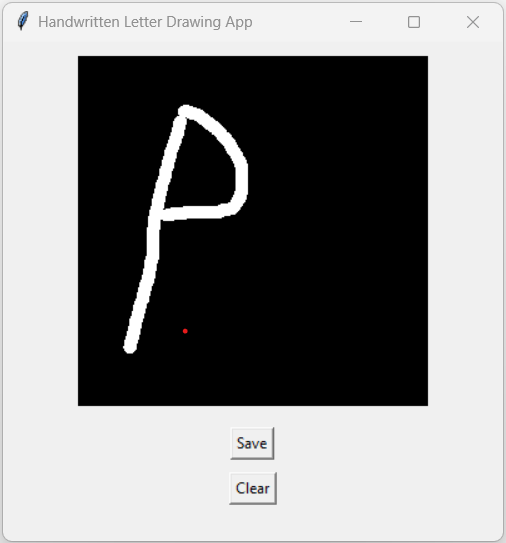

In [ ]:
image_path = "letter_image.png"
image = Image.open(image_path).convert('L')
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
image_tensor = transform(image)
image_tensor = image_tensor.unsqueeze(0)
image_tensor = image_tensor.transpose(2, 3)

model18.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
with torch.no_grad():
    output = model18(image_tensor)

top_k = 3
top_values, top_indices = torch.topk(output, top_k, dim=1)

predicted_classes = top_indices[0] + 1  
predicted_probabilities = torch.softmax(output, dim=1)[0][top_indices[0]]



alphabet_upper = string.ascii_uppercase
alphabet_lower = string.ascii_lowercase
top_k = 3
top_values, top_indices = torch.topk(output, top_k, dim=1)

predicted_classes = top_indices[0] + 1  
predicted_letters_upper = [alphabet_upper[index - 1] for index in predicted_classes]  
predicted_letters_lower = [alphabet_lower[index - 1] for index in predicted_classes]
predicted_probabilities = torch.softmax(output, dim=1)[0][top_indices[0]]

print("Top 3 Predicted Letters:")
for i in range(top_k):
    print(f"Letter: {predicted_letters_upper[i]}/{predicted_letters_lower[i]}, Probability: {predicted_probabilities[i].item()}")


Top 3 Predicted Letters:
Letter: P/p, Probability: 0.5573624968528748
Letter: F/f, Probability: 0.1676221787929535
Letter: Q/q, Probability: 0.052533794194459915


Input image: 

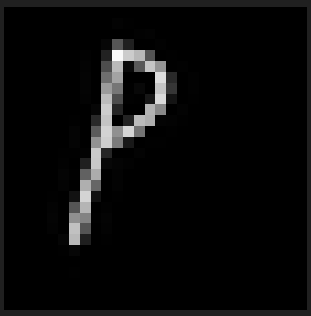

In [ ]:
image